# Dictionary learning

In [1]:
import numpy as np
import scipy
import types

from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Subroutines for first subproblem

def grad(Y, D, X): 
    return - Y @ X.T + D @ X @ X.T

def proj(D):

    return np.apply_along_axis(lambda d: d/np.max([1, np.linalg.norm(d)]), axis=0, arr=D)

def projected_gradient(Y, D, X, LR = 0.001, T = 100):
    for _ in range(T):
        D = proj ( D - LR * grad(Y,D,X))
    return D

In [3]:
# Subroutines for second subproblem

def ortho_match_pursuit(y, A, max_iter = 5, eps = 1e-2):
    S = []

    x = np.zeros(A.shape[1])
    iters = 0
    rate = 0
    R = y

    while iters < max_iter or rate > eps:

        # Retrieve the maximum correlation between atoms and residuals of the previous iteration
        S.append(np.argmax(np.abs(A.T @ R)))

        # Expand the dictionary for the representation
        dic = A[:,S]

        # Solve subproblems and update x
        x[S] = np.linalg.inv(dic.T @ dic) @ dic.T @ y
        
        # Update the residuals
        R = y - A @ x
        iters += 1

    return x


In [4]:
def SCADictionaryLearning(Y, m, epsilon = 1e-5, gamma = 0.99, max_iter = 200):
    s = Y.shape[0]
    t = Y.shape[1]

    D = np.random.rand(s,m)
    X = np.random.rand(m,t)

    '''
    for j in range(t):
        X[:,j] = Hs(X[:,j], k)
    '''
    # Normalize data
    Y = np.apply_along_axis(lambda x: x/np.linalg.norm(x), axis=0, arr=Y)
    
    loss = [np.linalg.norm(Y - D @ X)]
    rate = 1

    for it in tqdm(range(1,max_iter)): 
        if rate < epsilon:
            break

        D_hat = np.random.rand(D.shape[0],D.shape[1])
        X_hat = np.random.rand(X.shape[0],X.shape[1])

        # First subproblem - Normalized LS in the dictionary
        D_hat = projected_gradient(Y, D_hat, X)

        # Second subproblem - LASSO within each sample of signals
        X_hat = np.apply_along_axis(ortho_match_pursuit, 0, Y, A = D)

        # Convex combination
        
        D = D + gamma * (D_hat - D)
        X = X + gamma * (X_hat - X)
        
        # Decreasing step size 

        gamma *= 0.9
        
        '''
        D = D_hat
        X = X_hat
        '''
        
        # Metrics stores and update
        loss.append(np.linalg.norm(Y - D @ X))
        rate = np.abs(loss[it] - loss[it - 1])
        
    return D, X, loss

In [5]:
Y = np.random.rand(50,100)
Y += np.random.rand(50,100) * 0.01

In [6]:
D, X, loss = SCADictionaryLearning(Y, 100)

  0%|          | 0/199 [00:00<?, ?it/s]

 54%|█████▍    | 107/199 [00:27<00:23,  3.84it/s]


In [ ]:
plt.plot(loss)
plt.yscale('log')

____________

# DL through learnable nonconvex surrogates of $l_0$ norm

### Approach: neural-augmentation for sparse optimization step in dictionary learning algorithm 

In [2]:
def expSURROGATE(x, theta):
    return 1- np.exp(-theta*np.abs(x))

def pPosSURROGATE(x, eps, theta):
    return (np.abs(x) + eps)**(1/theta)

def pNegSURROGATE(x, theta, p):
    return 1 -(theta*np.abs(x) + 1)**p

def SCADSURROGATE(x, theta, a):
    if np.abs(x) <= 1/theta:
        return np.abs(x)*2*theta/(a+1)
    
    elif 1/theta <= np.abs(x) <= a/theta:
        return (-theta**2*np.abs(x)**2 + 2*a*theta*np.abs(x) - 1) / (a ** 2 - 1)
    
    else:
        return 1
    
def logSURROGATE(x, theta):
    return (np.log(1 + theta * np.abs(x))) / (np.log(1 + theta))


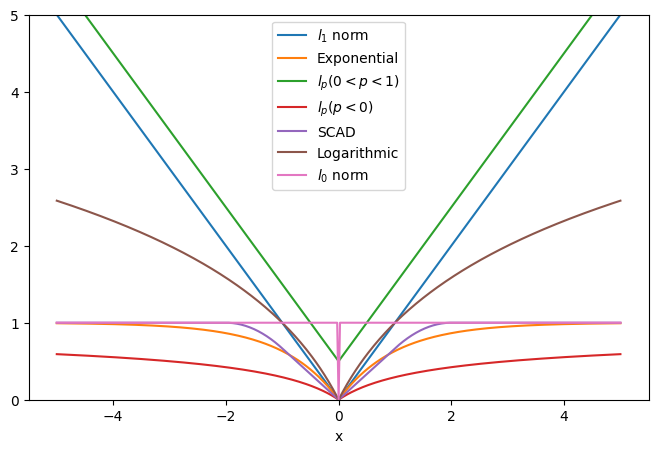

In [4]:
# Parameters
theta = 1
eps = 0.5
a = 2
p = - 0.5
x_values = np.linspace(-5, 5, 401)

exp_values = expSURROGATE(x_values, theta)
pNeg_values = pPosSURROGATE(x_values, eps, theta)
pPos_values = pNegSURROGATE(x_values, theta, p)
scad_values = np.array([SCADSURROGATE(x, theta, a) for x in x_values])
log_values = logSURROGATE(x_values, theta)

plt.figure(figsize=(8, 5))

plt.plot(x_values, np.abs(x_values), label = '$l_1$ norm')
plt.plot(x_values, exp_values, label='Exponential')
plt.plot(x_values, pNeg_values, label='$l_p (0 < p < 1)$')
plt.plot(x_values, pPos_values, label='$l_p (p < 0)$')
plt.plot(x_values, scad_values, label='SCAD')
plt.plot(x_values, log_values, label='Logarithmic')
plt.plot(x_values, (x_values != 0), label = '$l_0$ norm')
plt.ylim((0,5))

plt.xlabel('x')
plt.legend()
plt.show()

In [5]:
# Parametrization for the surrogates

def etaEXP(theta):
    return theta

def etaPOS(theta, eps):
    return 1 / theta * eps ** (1 / theta - 1)

def etaNEG(theta, p):
    return - p * theta

def etaSCAD(theta, a):
    return 2 * theta / (a + 1)

def etaLOG(theta):
    return theta / torch.log(theta + 1)

In [6]:
# Derivatives of the nonconvex components

def ddxEXP(theta, x):
    return torch.sign(x) * theta * (1 - torch.exp(-theta * torch.abs(x)))

def ddxPOS(theta, eps, x):
    return (1 / theta) * torch.sign(x) * (eps**(1 / theta - 1) - (torch.abs(x) + eps)**(1 / theta - 1))

def ddxNEG(theta, p, x):
    return -torch.sign(x) * p * theta * (1 - (1 + theta * torch.abs(x))**(p - 1))

def ddxSCAD(theta, x, a):
    abs_x = torch.abs(x)
    if abs_x <= 1 / theta:
        return torch.zeros_like(x)
    elif 1 / theta < abs_x <= a / theta:
        return torch.sign(x) * (2 * theta * (theta * abs_x - 1)) / (a**2 - 1)
    else:
        return torch.sign(x) * (2 * theta / (a + 1))

def ddxLOG(x, theta):
    return torch.sign(x) * (theta**2 * torch.abs(x)) / (torch.log(1 + theta) * (1 + theta * torch.abs(x)))

In [7]:
class SyntheticSignals():
    def __init__(self, A, n, m, s, s_sigma = 0.5, eps_sigma = 0.01, size = 1000, batch_size = 512):
        
        self.n = n          # Number of samples in the original signal
        self.m = m          # Number of samples through the linear transformation

        self.size = size    # Size of the dataset

        self.x = torch.zeros(self.size,self.n)
        self.y = torch.zeros(self.size,self.m)

        self.A = A          # Matrix for the linear observation

        self.s = s          # Sparsity of the signal

        self.s_sigma = s_sigma
        self.eps_sigma = eps_sigma

        self.batch_size = batch_size

        # Generating the dataset
        self.set_data()


    def set_tuple(self, i):

        # Generating random sparsity in the canonic basis of the original signal
        idxs = np.random.choice(self.m, self.s, replace=False)
        peaks = np.random.normal(scale=self.s_sigma, size = self.s)

        # Generating the original signal and its corrupted observations
        self.x[i, idxs] = torch.from_numpy(peaks).to(self.x)
        self.y[i,:] = self.A @ self.x[i,:] + np.random.normal(scale=self.eps_sigma, size=self.m)


    def set_data(self):
        for i in range(self.size):
            self.set_tuple(i)
    
    
    def set_loader(self):
        return Data.DataLoader(dataset = Data.TensorDataset(self.y, self.x),
                               batch_size = self.batch_size,
                               shuffle = True)

In [32]:
# Dimensions for the signal, its sparsity and its observation

m_ = 150
n_ = 200
s_ = 4

# Measurement matrix
A_ = torch.randn(m_,n_)
A_ /= torch.norm(A_, dim=0)

# Building a training set and a test set 
train_set = SyntheticSignals(A = A_,
                             n = n_,
                             m = m_,
                             s = s_,
                             size = 800).set_loader()

test_set = SyntheticSignals(A = A_,
                             n = n_,
                             m = m_,
                             s = s_,
                             size = 200).set_loader()

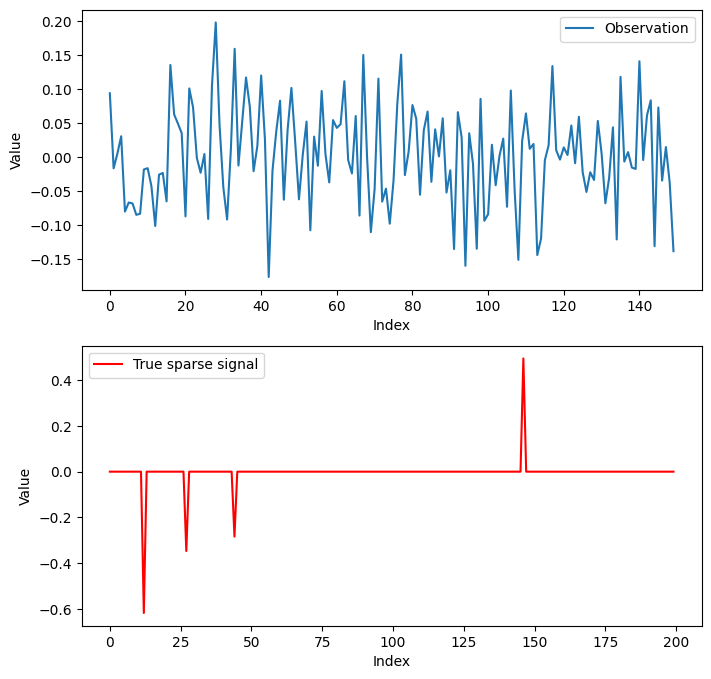

In [33]:
x_exm, s_exm =test_set.dataset.__getitem__(0)
plt.figure(figsize=(8, 8)) 
plt.subplot(2, 1, 1) 
plt.plot(x_exm, label = 'Observation' ) 
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.subplot (2, 1, 2) 
plt.plot(s_exm, label = 'True sparse signal', color='r')  
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend()
plt.show()

In [34]:
class NCS_EXP_LAYER(nn.Module):
    def __init__(self, A, lambd = 0.1):
        super().__init__()

        self.A = A
        self.L = 2*torch.max(torch.real(torch.linalg.eigvals(A.t() @ A)))
        self.lambd = lambd

        # Initialization of the learnable parameter
        self.theta = nn.Parameter(torch.randn(1), requires_grad=True)       
        
    def etaEXP(self):
        return self.theta
    
    def ddxEXP(self, x):
        return torch.sign(x) * self.theta * (1 - torch.exp(- self.theta * torch.abs(x)))
    
    def B(self, z, x):
        return x - 2/self.L*(x @ self.A.t() @ self.A - (self.A.t() @ z.t()).t()) + self.lambd/self.L * (self.ddxEXP(x))
    
    def _shrink(self, x, beta):
        return beta * F.softshrink(x / beta, lambd=1)
    
    def forward(self, z, x):   

        K = self.etaEXP() * self.lambd / self.L    
        if x is None:
            x = torch.zeros(z.shape[0], self.A.shape[1])

        return self._shrink(self.B(z, x), K)

In [35]:
class NCSEXP_Net(nn.Module):
    def __init__(self, A, lambd = 0.1, K = 5):
        super(NCSEXP_Net, self).__init__()

        # Number of layers <-> iterations
        self.K = K

        # Layers
        self.NCSEXP_layers = nn.ModuleList([NCS_EXP_LAYER(A, lambd) for _ in range(self.K + 1)])

        # Losses when doing inference
        self.losses = []

    def forward(self, z):     

        x = self.NCSEXP_layers[0].forward(z,None)

        for i in range(1, self.K + 1):
            
            x = self.NCSEXP_layers[i].forward(z,x)
                
        return x

In [36]:
def train(model, train_loader, valid_loader, num_epochs=50, verbose = True):

    # Initialization
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=5e-03,
        momentum=0.9,
        weight_decay=0,
    )
    
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=50, gamma=0.1
    )

    loss_train = np.zeros((num_epochs,))
    loss_test = np.zeros((num_epochs,))

    # Main train loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for _, (Y, S) in enumerate(train_loader):
            S_hat = model.forward(Y)
            loss = F.mse_loss(S_hat, S, reduction="sum")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.zero_grad()
            train_loss += loss.data.item()
        loss_train[epoch] = train_loss / len(train_loader.dataset)
        scheduler.step()

        # Validation
        model.eval()
        test_loss = 0
        for _, (Y, S) in enumerate(valid_loader):
            S_hat = model.forward(Y)
            loss = F.mse_loss(S_hat, S, reduction="sum")
            optimizer.zero_grad()
            test_loss += F.mse_loss(S_hat, S, reduction="sum").data.item()
        loss_test[epoch] = test_loss / len(valid_loader.dataset)

        # Log progress
        if verbose and epoch % 10 == 0:
            print(
                "Epoch %d, Train loss %.8f, Validation loss %.8f"
                % (epoch, loss_train[epoch], loss_test[epoch])
            )

    return loss_test

In [37]:
model = NCSEXP_Net(A_, 0.1, 5)

In [38]:
list(model.named_parameters())

[('NCSEXP_layers.0.theta',
  Parameter containing:
  tensor([-0.1170], requires_grad=True)),
 ('NCSEXP_layers.1.theta',
  Parameter containing:
  tensor([-0.9202], requires_grad=True)),
 ('NCSEXP_layers.2.theta',
  Parameter containing:
  tensor([1.1052], requires_grad=True)),
 ('NCSEXP_layers.3.theta',
  Parameter containing:
  tensor([-2.1656], requires_grad=True)),
 ('NCSEXP_layers.4.theta',
  Parameter containing:
  tensor([-1.5590], requires_grad=True)),
 ('NCSEXP_layers.5.theta',
  Parameter containing:
  tensor([0.1136], requires_grad=True))]

In [39]:
loss = train(model, train_set, test_set)

Epoch 0, Train loss 0.16346840, Validation loss 0.14168686
Epoch 10, Train loss 0.09403521, Validation loss 0.09538391
Epoch 20, Train loss 0.06567281, Validation loss 0.05914454
Epoch 30, Train loss 0.06268579, Validation loss 0.05824761
Epoch 40, Train loss 0.06319357, Validation loss 0.06014933


In [40]:
list(model.parameters())

[Parameter containing:
 tensor([-2.2187], requires_grad=True),
 Parameter containing:
 tensor([-1.5665], requires_grad=True),
 Parameter containing:
 tensor([2.5337], requires_grad=True),
 Parameter containing:
 tensor([-0.8729], requires_grad=True),
 Parameter containing:
 tensor([-3.8132], requires_grad=True),
 Parameter containing:
 tensor([0.4079], requires_grad=True)]

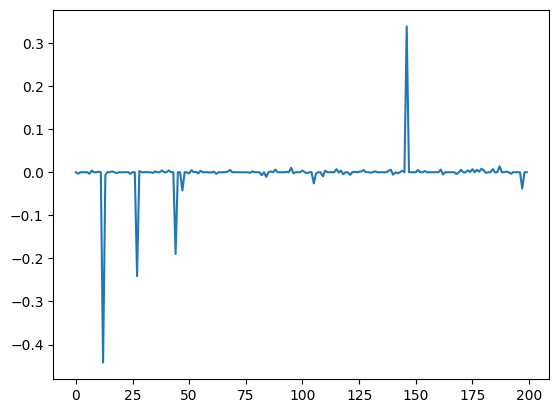

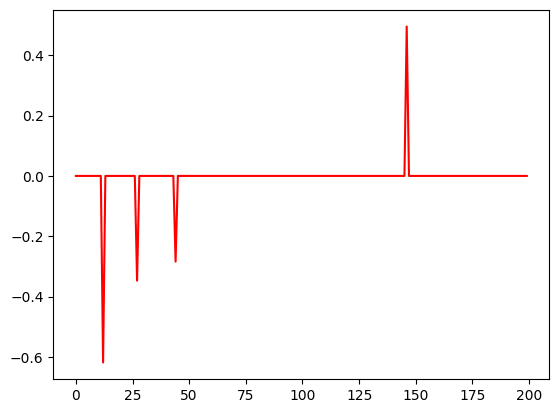

In [41]:
plt.plot(model.forward(x_exm[None,:])[0].detach().numpy())
plt.show()
plt.plot(s_exm, color='r')

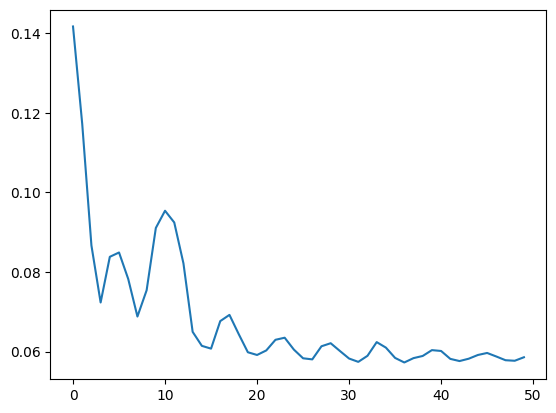

In [42]:
plt.plot(loss)

In [45]:
def ortho_match_pursuit(y, A, max_iter=4, eps=1e-2):
    S = []
    m = A.shape[1]
    x = torch.zeros(m, dtype=torch.float32, device=y.device)
    iters = 0
    R = y.clone()

    while iters < max_iter or torch.norm(R) > eps:
        # Retrieve the maximum correlation between atoms and residuals of the previous iteration
        correlations = torch.abs(A.t() @ R)
        max_idx = torch.argmax(correlations).item()
        S.append(max_idx)

        # Expand the dictionary for the representation
        dic = A[:, S]

        # Solve subproblems and update x
        if len(S) > 0:
            x_temp, _ = torch.lstsq(y, dic)
            x[S] = x_temp[:len(S)]

        # Update the residuals
        R = y - A @ x
        iters += 1

    return x

# Subroutines for first subproblem

def grad(Y, D, X): 
    return - Y @ X.t() + D @ X @ X.t()

def proj(D):
    norms = torch.norm(D, dim=0, keepdim=True)
    max_norms = torch.maximum(norms, torch.ones_like(norms))
    return D / max_norms

def projected_gradient(Y, D, X, LR = 0.001, T = 100):
    for _ in range(T):
        D = proj ( D - LR * grad(Y,D,X))
    return D

In [46]:
def normalize_columns(Y):
    return Y / torch.norm(Y, dim=0, keepdim=True)

def projected_gradient(Y, D, X, lr=0.01, num_iters=100):
    # Gradient descent for D
    for _ in range(num_iters):
        grad = -2 * (Y - D @ X) @ X.t()
        D -= lr * grad
        D = normalize_columns(D)  # Ensure columns of D are normalized
    return D

def ortho_match_pursuit(y, A, max_iter=5, eps=1e-2):
    S = []
    m = A.shape[1]
    x = torch.zeros(m, dtype=torch.float32, device=y.device)
    iters = 0
    R = y.clone()

    while iters < max_iter and torch.norm(R) > eps:
        # Retrieve the maximum correlation between atoms and residuals of the previous iteration
        correlations = torch.abs(A.t() @ R)
        max_idx = torch.argmax(correlations).item()
        S.append(max_idx)

        # Expand the dictionary for the representation
        dic = A[:, S]

        # Solve subproblems and update x
        if len(S) > 0:
            x_temp = torch.linalg.lstsq(dic, y).solution
            x[S] = x_temp

        # Update the residuals
        R = y - A @ x
        iters += 1

    return x

def SCADictionaryLearning(Y, m, epsilon=1e-5, gamma=0.99, max_iter=200):
    Y = torch.tensor(Y, dtype=torch.float32)
    s, t = Y.shape

    D = torch.rand(s, m, dtype=torch.float32)
    X = torch.rand(m, t, dtype=torch.float32)

    # Normalize data
    Y = normalize_columns(Y)
    
    loss = [torch.norm(Y - D @ X).item()]
    rate = 1.0

    for it in tqdm(range(1, max_iter)):

        D_hat = torch.rand_like(D)
        X_hat = torch.rand_like(X)

        # First subproblem - Normalized LS in the dictionary
        D_hat = projected_gradient(Y, D_hat, X)

        # Second subproblem - LASSO within each sample of signals
        X_hat = torch.stack([ortho_match_pursuit(Y[:, j], D) for j in range(t)], dim=1)

        # Convex combination
        D = D + gamma * (D_hat - D)
        X = X + gamma * (X_hat - X)
        
        # Decreasing step size 
        gamma *= 0.9
        
        # Metrics stores and update
        loss.append(torch.norm(Y - D @ X).item())
        
    return D, X, loss

In [47]:
def NASCADictionaryLearning_EXP(Y, L, K = 4, gamma=0.99, max_iter=200, verbose = False):

    Y = torch.tensor(Y, dtype=torch.float32)
    s, t = Y.shape

    D = torch.rand(s, L, dtype=torch.float32)
    X = torch.rand(L, t, dtype=torch.float32)

    # Normalize data
    Y = normalize_columns(Y)
    
    loss = [torch.norm(Y - D @ X).item()]

    for _ in tqdm(range(1, max_iter)):

        with torch.no_grad():

            D_0 = torch.rand_like(D)

            # First subproblem - Repeated projected gradient for constrained LS for the dictionary
            D_hat = projected_gradient(Y, D_0, X)

            # Second subproblem - LASSO within each sample of signals (neural augmentation)
            # ___________WARNING___________ 
            # The training phase should be redesigned to be on-the-fly or 
            # offline including the basis matrix in the synthetics signals
            # _____________________________
            
            train_set = SyntheticSignals(A = D_hat,
                                         n = D_hat.shape[1],
                                         m = D_hat.shape[0],
                                         s = int(K),
                                         size = 800).set_loader()

            test_set = SyntheticSignals(A = D_hat,
                                        n = D_hat.shape[1],
                                        m = D_hat.shape[0],
                                        s = int(K),
                                        size = 200).set_loader()
        
        model = NCSEXP_Net(D_hat, 0.1, 5)
        train(model, train_set, test_set, verbose = verbose)
        X_hat = (model.forward(Y.t())).t()
        
        with torch.no_grad():

            # Convex combination
            D = D + gamma * (D_hat - D)
            X = X + gamma * (X_hat - X)

            # Decreasing step size 
            gamma *= 0.9
            
            # Metrics stores and update
            loss.append(torch.norm(Y - D @ X).item())
        
    return D, X, loss

In [48]:
# Synthetic observations to try the algo
A_ = np.random.randn(150,200)
A_ /= np.linalg.norm(A_, axis=0)

X = np.random.randn(200,1000)

mask = np.zeros_like(X)

for col in range(X.shape[1]):
    indices = np.arange(X.shape[0])
    selected_indices = np.random.choice(indices, 4, replace=False)
    mask[selected_indices, col] = X[selected_indices, col]

Y = A_ @ mask + np.random.randn(A_.shape[0], mask.shape[1])*0.01


In [ ]:
D1, X1, loss1 = SCADictionaryLearning(Y, 150, max_iter = 100)
D2, X2, loss2 = NASCADictionaryLearning_EXP(Y, 150, max_iter=100, verbose = False)

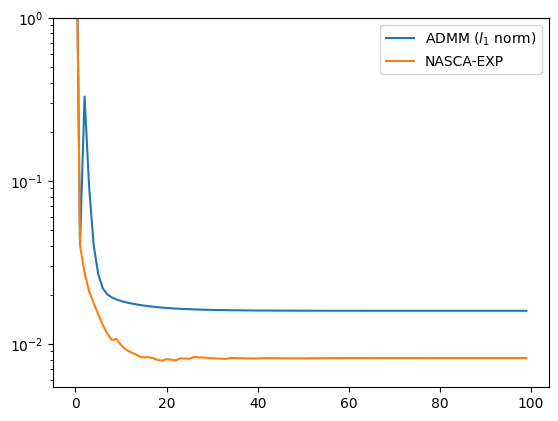

In [219]:
plt.plot([L / 1000 for L in loss1], label = 'ADMM ($l_1$ norm)')
plt.plot([L / 1000 for L in loss2], label = 'NASCA-EXP')
plt.yscale('log')
plt.ylim((0,1))

plt.legend()

________

# Let's build a general model for the other surrogates

In [49]:
class NCS_LAYER(nn.Module):
    def __init__(self, A, mode, lambd = 0.1):
        super().__init__()

        self.A = A
        self.L = 2*torch.max(torch.real(torch.linalg.eigvals(A.t() @ A)))
        self.lambd = lambd
        self.mode = mode

        # Initialization of the learnable parameter
        self.theta = nn.Parameter(torch.rand(1), requires_grad=True)  

        # Mode setting for the layer
        if mode == 'EXP':
            self.ddx = self.ddxEXP
            self.eta = self.etaEXP

        if mode == 'PPOS':     
            self.eps = 1
            self.ddx = self.ddxPOS
            self.eta = self.etaPOS

        if mode == 'PNEG':
            self.p = 0.5
            self.ddx = self.ddxNEG
            self.eta = self.etaNEG

        if mode == 'SCAD':
            self.a = 2
            self.ddx = self.ddxSCAD
            self.eta = self.etaSCAD

        if mode == 'LOG':
            self.ddx = self.ddxLOG
            self.eta = self.etaLOG

    #_________________________________________________________________
    #______________ METHODS FOR ENABLING DIFFERENT LAYERS_____________

    # Derivatives of the nonconvex components
    def ddxEXP(self, x):
        return torch.sign(x) * self.theta * (1 - torch.exp(-self.theta * torch.abs(x)))

    def ddxPOS(self, x):
        return (1 / self.theta) * torch.sign(x) * (self.eps**(1 / self.theta - 1) - (torch.abs(x) + self.eps)**(1 / self.theta - 1))

    def ddxNEG(self, x):
        return -torch.sign(x) * self.p * self.theta * (1 - (1 + self.theta * torch.abs(x))**(self.p - 1))

    def ddxSCAD(self, x):
        abs_x = torch.abs(x)
        
        mask1 = (abs_x <= 1)
        mask2 = (1 / self.theta < abs_x) & (abs_x <= self.a / self.theta)
        mask3 = (abs_x > self.a / self.theta)
        
        # Compute the value for each condition
        val1 = torch.zeros_like(x)
        val2 = torch.sign(x) * (2 * self.theta * (self.theta * abs_x - 1)) / (self.a**2 - 1)
        val3 = torch.sign(x) * (2 * self.theta / (self.a + 1))
        
        # Apply the masks to compute the final result
        result = torch.where(mask1, val1, torch.where(mask2, val2, val3))
        
        return result


    def ddxLOG(self, x):
        return torch.sign(x) * (self.theta**2 * torch.abs(x)) / (torch.log(1 + self.theta) * (1 + self.theta * torch.abs(x)))

    # Parametrization for the surrogates
    def etaEXP(self):
        return self.theta

    def etaPOS(self):
        return 1 / self.theta * self.eps ** (1 / self.theta - 1)

    def etaNEG(self):
        return - self.p * self.theta

    def etaSCAD(self):
        return 2 * self.theta / (self.a + 1)

    def etaLOG(self):
        return self.theta**2 / torch.log(self.theta**2 + 1)
    
    #___________________________________________________________________
    #___________________________________________________________________

    def B(self, z, x):
        return x - 2/self.L*(x @ self.A.t() @ self.A - (self.A.t() @ z.t()).t()) + self.lambd/self.L * (self.ddx(x))

    def _shrink(self, x, beta):
        return beta * F.softshrink(x / beta, lambd=1)

    def forward(self, z, x):   

        K = self.eta() * self.lambd / self.L    
        if x is None:
            x = torch.zeros(z.shape[0], self.A.shape[1])

        return self._shrink(self.B(z, x), K)

In [50]:
class NCS_Net(nn.Module):
    def __init__(self, A, mode, lambd = 0.1, K = 5):
        super(NCS_Net, self).__init__()

        # Number of layers <-> iterations
        self.K = K

        # Layers
        self.NCS_layers = nn.ModuleList([NCS_LAYER(A, mode, lambd) for _ in range(self.K + 1)])

        # Losses when doing inference
        self.losses = []

    def forward(self, z):     

        x = self.NCS_layers[0].forward(z,None)

        for i in range(1, self.K + 1):
            
            x = self.NCS_layers[i].forward(z,x)
                
        return x

In [51]:
# Dimensions for the signal, its sparsity and its observation

m_ = 150
n_ = 200
s_ = 4

# Measurement matrix
A_ = torch.randn(m_,n_)
A_ /= torch.norm(A_, dim=0)

# Building a training set and a test set 
train_set = SyntheticSignals(A = A_,
                             n = n_,
                             m = m_,
                             s = s_,
                             size = 800).set_loader()

test_set = SyntheticSignals(A = A_,
                             n = n_,
                             m = m_,
                             s = s_,
                             size = 200).set_loader()

In [52]:
model = NCS_Net(A_, 'LOG', 0.1, 5)

In [53]:
list(model.named_parameters())

[('NCS_layers.0.theta',
  Parameter containing:
  tensor([0.3774], requires_grad=True)),
 ('NCS_layers.1.theta',
  Parameter containing:
  tensor([0.5656], requires_grad=True)),
 ('NCS_layers.2.theta',
  Parameter containing:
  tensor([0.2511], requires_grad=True)),
 ('NCS_layers.3.theta',
  Parameter containing:
  tensor([0.5077], requires_grad=True)),
 ('NCS_layers.4.theta',
  Parameter containing:
  tensor([0.3782], requires_grad=True)),
 ('NCS_layers.5.theta',
  Parameter containing:
  tensor([0.8975], requires_grad=True))]

In [54]:
loss = train(model, train_set, test_set)

Epoch 0, Train loss 0.18233912, Validation loss 0.18890205
Epoch 10, Train loss 0.13738607, Validation loss 0.14218136
Epoch 20, Train loss 0.13550029, Validation loss 0.14029936
Epoch 30, Train loss 0.13481031, Validation loss 0.14002718
Epoch 40, Train loss 0.13464762, Validation loss 0.13976894


In [55]:
def NASCADictionaryLearning(Y, L, mode, K = 4, gamma=0.99, max_iter=200, verbose = False):

    Y = torch.tensor(Y, dtype=torch.float32)
    s, t = Y.shape

    D = torch.rand(s, L, dtype=torch.float32)
    X = torch.rand(L, t, dtype=torch.float32)

    # Normalize data
    Y = normalize_columns(Y)
    
    loss = [torch.norm(Y - D @ X).item()]

    for _ in tqdm(range(1, max_iter)):

        with torch.no_grad():

            D_0 = torch.rand_like(D)

            # First subproblem - Repeated projected gradient for constrained LS for the dictionary
            D_hat = projected_gradient(Y, D_0, X)

            # Second subproblem - LASSO within each sample of signals (neural augmentation)
            # ___________WARNING___________ 
            # The training phase should be redesigned to be on-the-fly or 
            # offline including the basis matrix in the synthetics signals
            # _____________________________
            
            train_set = SyntheticSignals(A = D_hat,
                                         n = D_hat.shape[1],
                                         m = D_hat.shape[0],
                                         s = int(K),
                                         size = 800).set_loader()

            test_set = SyntheticSignals(A = D_hat,
                                        n = D_hat.shape[1],
                                        m = D_hat.shape[0],
                                        s = int(K),
                                        size = 200).set_loader()
        
        model = NCS_Net(D_hat, mode, 0.1, 5)
        train(model, train_set, test_set, verbose = verbose)
        X_hat = (model.forward(Y.t())).t()
        
        with torch.no_grad():

            # Convex combination
            D = D + gamma * (D_hat - D)
            X = X + gamma * (X_hat - X)

            # Decreasing step size 
            gamma *= 0.9
            
            # Metrics stores and update
            loss.append(torch.norm(Y - D @ X).item())
        
    return D, X, loss

In [56]:
# Synthetic observations to try the algo
A_ = np.random.randn(150,200)
A_ /= np.linalg.norm(A_, axis=0)

X = np.random.randn(200,1000)

mask = np.zeros_like(X)

for col in range(X.shape[1]):
    indices = np.arange(X.shape[0])
    selected_indices = np.random.choice(indices, 4, replace=False)
    mask[selected_indices, col] = X[selected_indices, col]

Y = A_ @ mask + np.random.randn(A_.shape[0], mask.shape[1])*0.01

In [ ]:
D1, X1, loss1 = SCADictionaryLearning(Y, 150, max_iter = 100)
D2, X2, loss2 = NASCADictionaryLearning(Y, 150, 'EXP', max_iter=100, verbose = False)
D3, X3, loss3 = NASCADictionaryLearning(Y, 150, 'PPOS', max_iter=100, verbose = False)
D4, X4, loss4 = NASCADictionaryLearning(Y, 150, 'PNEG', max_iter=100, verbose = False)
D5, X5, loss5 = NASCADictionaryLearning(Y, 150, 'SCAD', max_iter=100, verbose = False)
D6, X6, loss6 = NASCADictionaryLearning(Y, 150, 'LOG', max_iter=100, verbose = False)

In [ ]:
plt.plot([L / 1000 for L in loss1], label = 'ADMM ($l_1$ norm)')
plt.plot([L / 1000 for L in loss2], label = 'NASCA-EXP')
plt.plot([L / 1000 for L in loss3], label = 'NASCA-PPOS')
plt.plot([L / 1000 for L in loss4], label = 'NASCA-PNEG')
plt.plot([L / 1000 for L in loss5], label = 'NASCA-SCAD')
plt.plot([L / 1000 for L in loss6], label = 'NASCA-LOG')

plt.yscale('log')
plt.ylim((0,1))

plt.legend()